# ENSF 611 – Phishing URL Classification Full Pipeline

This notebook implements a full machine learning pipeline for phishing URL detection with:

- NaN checking and cleaning
- 50% **training**, 30% **validation**, 20% **test** split (stratified)
- Feature screening using correlation, ANOVA F-test, and mutual information
- Selection of the **top 10 non-redundant features**
- Three models:
  - Logistic Regression
  - Random Forest Classifier
  - Support Vector Machine (SVM)
- Hyperparameter tuning using **cross-validation (CV)** on the training set
- Rich metric evaluation on:
  - CV on the training set
  - Validation set (30%)
  - Test set (20%)
- Plots:
  - Confusion matrices
  - ROC curves
  - Precision–Recall curves
  - Threshold curves (TPR/FPR vs threshold)
  - Learning curves
- Simple data-leakage sanity checks


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    StratifiedKFold,
    learning_curve,
    cross_val_predict,
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.feature_selection import mutual_info_classif, f_classif
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    balanced_accuracy_score,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    log_loss,
    matthews_corrcoef,
    classification_report,
)

import warnings
from sklearn.exceptions import DataConversionWarning

warnings.filterwarnings('ignore', category=DataConversionWarning)

RANDOM_STATE = 42
sns.set(style='whitegrid')


## 1. Load dataset

Replace the cell below with your **actual dataset loading code** so that:

- `X` is a pandas **DataFrame** of features
- `y` is a 1D **Series** of labels (e.g., 0 = phishing, 1 = legitimate)

Examples:

```python
df = pd.read_csv('phishing.csv')
y = df['Label']
X = df.drop(columns=['Label'])
```


In [2]:
from ucimlrepo import fetch_ucirepo
phiusiil_phishing_url_website = fetch_ucirepo(id=967)
X = phiusiil_phishing_url_website.data.features.copy()
y = phiusiil_phishing_url_website.data.targets.copy()
RANDOM_STATE = 42
SAMPLE_FRAC = 0.10   # 10% of full dataset

# Take a stratified 10% sample so class balance is preserved
X_small, _, y_small, _ = train_test_split(
    X,
    y,
    test_size=1 - SAMPLE_FRAC,
    random_state=RANDOM_STATE,
    stratify=y,
)

print("Original size:", X.shape[0])
print("Sample size  :", X_small.shape[0])

# From this point on, use the sampled data
X = X_small
y = y_small


Original size: 235795
Sample size  : 23579


## 2. NaN check and cleaning

This cell:
- Ensures `y` is a 1D Series
- Reports NaNs per feature
- Drops rows with NaNs in `y` or any feature in `X`


In [3]:
import pandas as pd
import numpy as np

# Ensure y is a 1D Series aligned with X
if isinstance(y, pd.DataFrame):
    if y.shape[1] != 1:
        raise ValueError(f'y has {y.shape[1]} columns; expected 1 label column.')
    y = y.iloc[:, 0]

if not isinstance(y, pd.Series):
    y = pd.Series(y, index=X.index, name='target')

print('NaNs per feature (top 30):')
na_counts = X.isna().sum()
display(na_counts.sort_values(ascending=False).head(30))

any_nan_X = X.isna().values.any()
any_nan_y = pd.isna(y).values.any()

print('\nAny NaNs in X?:', bool(any_nan_X))
print('Any NaNs in y?:', bool(any_nan_y))

# 1) Drop rows where y is NaN
if any_nan_y:
    good_y = ~pd.isna(y)
    print('Rows with NaN in y:', (~good_y).sum())
    X = X.loc[good_y].copy()
    y = y.loc[good_y].copy()
    print('After dropping NaN rows in y, new shape:', X.shape)

# 2) Drop rows with any NaN in X
if any_nan_X:
    rows_with_nan = X.isna().any(axis=1).sum()
    print('Rows with any NaN in X:', rows_with_nan)
    X = X.dropna(axis=0)
    y = y.loc[X.index].copy()
    print('After dropping NaN rows in X, new shape:', X.shape)
else:
    print('No NaNs in X; nothing to drop.')


NaNs per feature (top 30):


URL                           0
URLLength                     0
Domain                        0
DomainLength                  0
IsDomainIP                    0
TLD                           0
URLSimilarityIndex            0
CharContinuationRate          0
TLDLegitimateProb             0
URLCharProb                   0
TLDLength                     0
NoOfSubDomain                 0
HasObfuscation                0
NoOfObfuscatedChar            0
ObfuscationRatio              0
NoOfLettersInURL              0
LetterRatioInURL              0
NoOfDegitsInURL               0
DegitRatioInURL               0
NoOfEqualsInURL               0
NoOfQMarkInURL                0
NoOfAmpersandInURL            0
NoOfOtherSpecialCharsInURL    0
SpacialCharRatioInURL         0
IsHTTPS                       0
LineOfCode                    0
LargestLineLength             0
HasTitle                      0
Title                         0
DomainTitleMatchScore         0
dtype: int64


Any NaNs in X?: False
Any NaNs in y?: False
No NaNs in X; nothing to drop.


## 3. 50% train, 30% validation, 20% test split (stratified)

We split the data as:

- 80% temp / 20% test
- then from the 80% temp: 62.5% train, 37.5% val → overall 50% / 30% / 20%.


In [4]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'bool']).columns.tolist()

print('Numeric features    :', len(numeric_features))
print('Categorical features:', len(categorical_features))

# 80% temp (train+val) / 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    random_state=RANDOM_STATE,
    stratify=y,
)

# From 80% temp, split into 50% train, 30% val overall
# val_fraction_of_temp = 0.30 / 0.80 = 0.375
X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp,
    y_temp,
    test_size=0.375,
    random_state=RANDOM_STATE,
    stratify=y_temp,
)

y_train = np.ravel(y_train)
y_valid = np.ravel(y_valid)
y_test  = np.ravel(y_test)

print('Train shape:', X_train.shape)   # ~50%
print('Valid shape:', X_valid.shape)   # ~30%
print('Test shape :', X_test.shape)    # ~20%


Numeric features    : 50
Categorical features: 4
Train shape: (11789, 54)
Valid shape: (7074, 54)
Test shape : (4716, 54)


## 4. Correlation analysis and redundant numeric features

We compute a correlation matrix on the training numeric features and mark numeric features as redundant if
they have |r| ≥ 0.80 with another numeric feature.


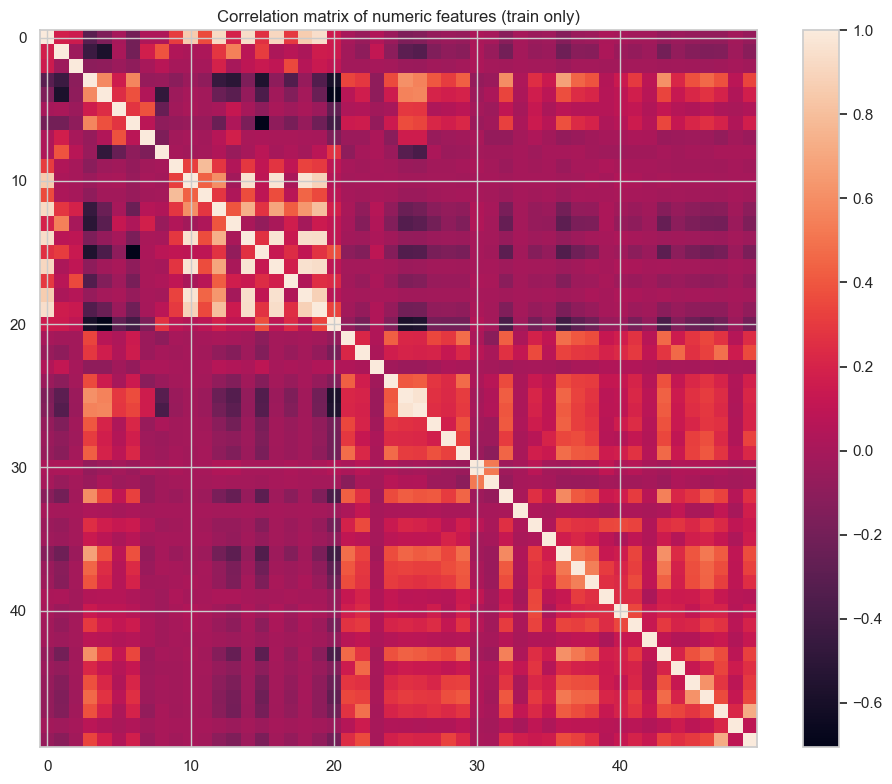

Highly correlated redundant numeric features (to avoid): ['NoOfObfuscatedChar', 'NoOfLettersInURL', 'NoOfDegitsInURL', 'NoOfEqualsInURL', 'NoOfAmpersandInURL', 'NoOfOtherSpecialCharsInURL', 'URLTitleMatchScore']


In [5]:
train_numeric = X_train[numeric_features]

if len(numeric_features) > 0:
    plt.figure(figsize=(10, 8))
    plt.imshow(train_numeric.corr())
    plt.colorbar()
    plt.title('Correlation matrix of numeric features (train only)')
    plt.tight_layout()
    plt.show()

CORR_THRESHOLD = 0.80

if len(numeric_features) > 0:
    corr_matrix = train_numeric.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    high_corr = [
        column
        for column in upper.columns
        if any(upper[column] >= CORR_THRESHOLD)
    ]
else:
    high_corr = []

print('Highly correlated redundant numeric features (to avoid):', high_corr)


## 5. Feature usefulness (mutual information & ANOVA)

We compute:
- ANOVA F-test and p-values for numeric features
- Mutual information for both numeric and categorical features


In [6]:
MI_THRESHOLD = 0.02
P_THRESHOLD = 0.10

results = []

# Numeric: ANOVA + MI
if len(numeric_features) > 0:
    f_vals, f_p = f_classif(X_train[numeric_features], y_train)
    mi_num = mutual_info_classif(
        X_train[numeric_features],
        y_train,
        random_state=RANDOM_STATE,
    )
    for i, col in enumerate(numeric_features):
        results.append({
            'feature': col,
            'type': 'numeric',
            'anova_f': f_vals[i],
            'anova_p': f_p[i],
            'mutual_info': mi_num[i],
        })

# Categorical: OrdinalEncoder + MI
if len(categorical_features) > 0:
    oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X_train_cat_enc = oe.fit_transform(X_train[categorical_features])
    mi_cat = mutual_info_classif(
        X_train_cat_enc,
        y_train,
        discrete_features=True,
        random_state=RANDOM_STATE,
    )
    for i, col in enumerate(categorical_features):
        results.append({
            'feature': col,
            'type': 'categorical',
            'anova_f': np.nan,
            'anova_p': np.nan,
            'mutual_info': mi_cat[i],
        })

feature_usefulness = pd.DataFrame(results)
feature_usefulness_sorted = feature_usefulness.sort_values(by='mutual_info', ascending=False)

feature_usefulness_sorted.head(20)


,feature,type,anova_f,anova_p,mutual_info
50,URL,categorical,NaN,NaN,0.682775
51,Domain,categorical,NaN,NaN,0.682775
53,Title,categorical,NaN,NaN,0.677353
3,URLSimilarityIndex,numeric,32862.868552,0.000000e+00,0.661042
22,LineOfCode,numeric,1592.628577,0.000000e+00,0.595779
49,NoOfExternalRef,numeric,2126.579866,0.000000e+00,0.565022
44,NoOfImage,numeric,786.992828,1.089755e-167,0.546405
47,NoOfSelfRef,numeric,2819.705144,0.000000e+00,0.524372
46,NoOfJS,numeric,5065.751105,0.000000e+00,0.494472
23,LargestLineLength,numeric,20.018138,7.742958e-06,0.455289


## 6. Select top 10 non-redundant features

We select the top 10 features by mutual information, skipping numeric features marked as redundant by high correlation.


In [7]:
TOP_K = 10

numeric_nonredundant = [c for c in numeric_features if c not in high_corr]

print('Numeric non-redundant candidates:', len(numeric_nonredundant))
print('Redundant numeric features (high_corr):', high_corr)

feat_sorted = feature_usefulness.sort_values(by='mutual_info', ascending=False)

selected_features = []

for _, row in feat_sorted.iterrows():
    feat_name = row['feature']
    feat_type = row['type']

    if feat_type == 'numeric' and feat_name not in numeric_nonredundant:
        continue

    if feat_name in selected_features:
        continue

    selected_features.append(feat_name)

    if len(selected_features) >= TOP_K:
        break

print(f'\nSelected top {len(selected_features)} non-redundant features (by mutual_info):')
print(selected_features)

X_train_sel = X_train[selected_features].copy()
X_valid_sel = X_valid[selected_features].copy()
X_test_sel  = X_test[selected_features].copy()

numeric_features_sel = [f for f in selected_features if f in numeric_features]
categorical_features_sel = [f for f in selected_features if f in categorical_features]

print('\nSelected numeric features     :', len(numeric_features_sel))
print('Selected categorical features :', len(categorical_features_sel))


Numeric non-redundant candidates: 43
Redundant numeric features (high_corr): ['NoOfObfuscatedChar', 'NoOfLettersInURL', 'NoOfDegitsInURL', 'NoOfEqualsInURL', 'NoOfAmpersandInURL', 'NoOfOtherSpecialCharsInURL', 'URLTitleMatchScore']

Selected top 10 non-redundant features (by mutual_info):
['URL', 'Domain', 'Title', 'URLSimilarityIndex', 'LineOfCode', 'NoOfExternalRef', 'NoOfImage', 'NoOfSelfRef', 'NoOfJS', 'LargestLineLength']

Selected numeric features     : 7
Selected categorical features : 3


## 7. Preprocessing and model definitions

We build a ColumnTransformer for preprocessing and define three classifiers with hyperparameter grids.


In [8]:
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features_sel),
        ('cat', categorical_transformer, categorical_features_sel),
    ]
)

models = {
    'log_reg': LogisticRegression(max_iter=500, random_state=RANDOM_STATE),
    'rf': RandomForestClassifier(random_state=RANDOM_STATE),
    'svm': SVC(probability=True, random_state=RANDOM_STATE),
}

param_grids = {
    'log_reg': {
        'clf__penalty': ['l2'],
        'clf__C': [0.1, 1, 5, 10],
        'clf__solver': ['lbfgs'],
    },
    'rf': {
        'clf__n_estimators': [100, 300],
        'clf__max_depth': [None, 10, 20],
        'clf__min_samples_split': [2, 5],
    },
    'svm': {
        'clf__C': [0.5, 1, 5],
        'clf__kernel': ['rbf', 'linear'],
        'clf__gamma': ['scale', 'auto'],
    },
}


## 8. Hyperparameter tuning with GridSearchCV (on training set)

Each model is wrapped in a pipeline with preprocessing and tuned using 5-fold CV on the training set, optimizing F1.


In [9]:
best_models = {}

for name, model in models.items():
    print(f'Training {name} with GridSearchCV...')
    pipe = Pipeline(steps=[('preprocess', preprocessor), ('clf', model)])

    grid = GridSearchCV(
        pipe,
        param_grids[name],
        cv=5,
        n_jobs=-1,
        scoring='f1',
        verbose=1,
    )

    grid.fit(X_train_sel, y_train)
    best_models[name] = grid

    print(f'Best params for {name}: {grid.best_params_}')
    print(f'Best CV F1 (GridSearchCV internal): {grid.best_score_:.4f}')
    print('-' * 70)


Training log_reg with GridSearchCV...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best params for log_reg: {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Best CV F1 (GridSearchCV internal): 0.9969
----------------------------------------------------------------------
Training rf with GridSearchCV...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params for rf: {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}
Best CV F1 (GridSearchCV internal): 0.9997
----------------------------------------------------------------------
Training svm with GridSearchCV...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params for svm: {'clf__C': 5, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}
Best CV F1 (GridSearchCV internal): 0.9973
----------------------------------------------------------------------


## 9. Helper: compute rich binary classification metrics

This helper returns many metrics at once, including accuracy, F1, MCC, AUCs, specificity, NPV, and log loss.


In [10]:
def binary_metrics(y_true, y_pred, y_score):
    """Compute a suite of binary classification metrics.
    y_score: probabilities or decision scores for the positive class.
    """
    acc  = accuracy_score(y_true, y_pred)
    bal  = balanced_accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec  = recall_score(y_true, y_pred)
    f1   = f1_score(y_true, y_pred)
    mcc  = matthews_corrcoef(y_true, y_pred)

    try:
        roc_auc = roc_auc_score(y_true, y_score)
    except ValueError:
        roc_auc = np.nan

    precision_arr, recall_arr, _ = precision_recall_curve(y_true, y_score)
    pr_auc = average_precision_score(y_true, y_score)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan
    npv = tn / (tn + fn) if (tn + fn) > 0 else np.nan

    try:
        if hasattr(y_score, 'ndim') and y_score.ndim == 1:
            probs = np.vstack([1 - y_score, y_score]).T
        else:
            probs = y_score
        ll = log_loss(y_true, probs)
    except Exception:
        ll = np.nan

    return {
        'accuracy': acc,
        'balanced_acc': bal,
        'precision': prec,
        'recall': rec,
        'specificity': specificity,
        'npv': npv,
        'f1': f1,
        'mcc': mcc,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'log_loss': ll,
    }


## 10. Cross-validation metrics on the training set

We use 5-fold stratified cross-validation on the training set to get robust estimates of model performance.


In [11]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_results = []

for name, grid in best_models.items():
    est = grid.best_estimator_

    y_pred_cv = cross_val_predict(
        est,
        X_train_sel,
        y_train,
        cv=cv,
        n_jobs=-1,
        method='predict',
    )

    if hasattr(est, 'predict_proba'):
        y_score_cv = cross_val_predict(
            est,
            X_train_sel,
            y_train,
            cv=cv,
            n_jobs=-1,
            method='predict_proba',
        )[:, 1]
    else:
        y_score_cv = cross_val_predict(
            est,
            X_train_sel,
            y_train,
            cv=cv,
            n_jobs=-1,
            method='decision_function',
        )

    metrics_cv = binary_metrics(y_train, y_pred_cv, y_score_cv)
    metrics_cv['model'] = name
    cv_results.append(metrics_cv)

cv_metrics_df = pd.DataFrame(cv_results).set_index('model').sort_values('f1', ascending=False)
print('Cross-validation metrics (on TRAIN set, 5-fold):')
display(cv_metrics_df)


Cross-validation metrics (on TRAIN set, 5-fold):


,accuracy,balanced_acc,precision,recall,specificity,npv,f1,mcc,roc_auc,pr_auc,log_loss
model,,,,,,,,,,,
rf,0.999661,0.999654,0.999703,0.999703,0.999604,0.999604,0.999703,0.999307,0.999990,0.999991,0.010092
svm,0.997031,0.996533,0.994835,1.000000,0.993065,1.000000,0.997411,0.993950,0.999929,0.999938,0.006180
log_reg,0.996268,0.995666,0.993662,0.999852,0.991480,0.999800,0.996747,0.992396,0.999875,0.999855,0.008528


### 10.1 CV confusion matrices and ROC curves

We visualize confusion matrices and ROC curves based on cross-validated predictions on the training set.


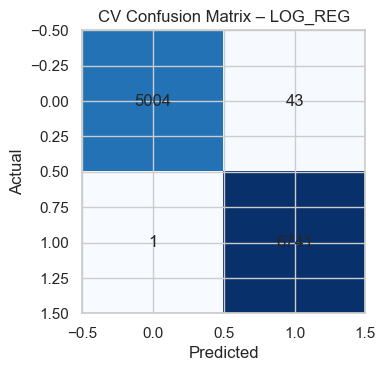

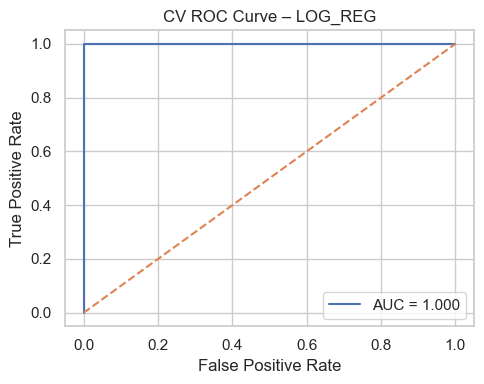

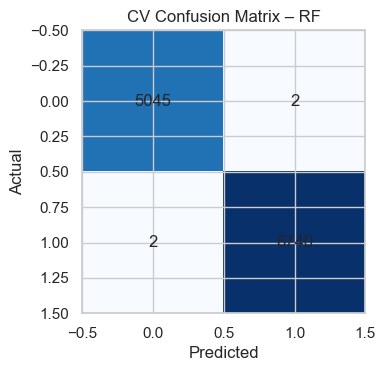

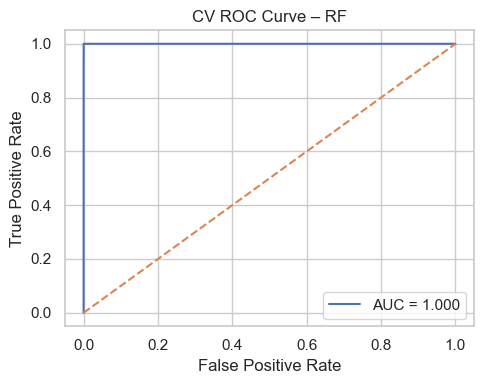

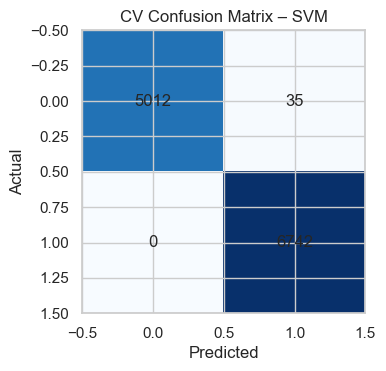

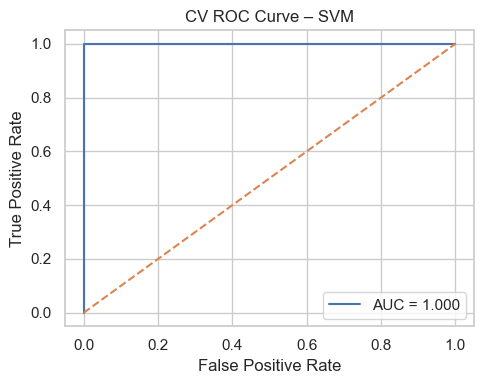

In [20]:
for name, grid in best_models.items():
    est = grid.best_estimator_

    y_pred_cv = cross_val_predict(
        est,
        X_train_sel,
        y_train,
        cv=cv,
        n_jobs=-1,
        method='predict',
    )

    if hasattr(est, 'predict_proba'):
        y_score_cv = cross_val_predict(
            est,
            X_train_sel,
            y_train,
            cv=cv,
            n_jobs=-1,
            method='predict_proba',
        )[:, 1]
    else:
        y_score_cv = cross_val_predict(
            est,
            X_train_sel,
            y_train,
            cv=cv,
            n_jobs=-1,
            method='decision_function',
        )

    cm_cv = confusion_matrix(y_train, y_pred_cv)
    plt.figure(figsize=(4, 4))
    plt.imshow(cm_cv,cmap='Blues')
    plt.title(f'CV Confusion Matrix – {name.upper()}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    for (i, j), val in np.ndenumerate(cm_cv):
        plt.text(j, i, str(val), ha='center', va='center')
    plt.tight_layout()
    plt.show()

    fpr, tpr, _ = roc_curve(y_train, y_score_cv)
    try:
        auc_cv = roc_auc_score(y_train, y_score_cv)
    except ValueError:
        auc_cv = float('nan')

    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f'AUC = {auc_cv:.3f}')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'CV ROC Curve – {name.upper()}')
    plt.legend()
    plt.tight_layout()
    plt.show()


## 11. Validation-set metrics (30% split)

Here we evaluate tuned models on the 30% validation set, which was not used for training or CV.


In [13]:
val_results = []

for name, grid in best_models.items():
    est = grid.best_estimator_

    y_pred_val = est.predict(X_valid_sel)

    if hasattr(est, 'predict_proba'):
        y_score_val = est.predict_proba(X_valid_sel)[:, 1]
    else:
        y_score_val = est.decision_function(X_valid_sel)

    metrics_val = binary_metrics(y_valid, y_pred_val, y_score_val)
    metrics_val['model'] = name
    val_results.append(metrics_val)

val_metrics_df = pd.DataFrame(val_results).set_index('model').sort_values('f1', ascending=False)
print('Validation-set metrics (30% split):')
display(val_metrics_df)


Validation-set metrics (30% split):


,accuracy,balanced_acc,precision,recall,specificity,npv,f1,mcc,roc_auc,pr_auc,log_loss
model,,,,,,,,,,,
svm,0.999717,0.999670,0.999506,1.0,0.999339,1.0,0.999753,0.999423,1.0,1.0,0.002133
rf,0.999576,0.999505,0.999259,1.0,0.999009,1.0,0.999629,0.999134,1.0,1.0,0.009345
log_reg,0.998021,0.997688,0.996552,1.0,0.995376,1.0,0.998273,0.995964,1.0,1.0,0.004212


### 11.1 Validation confusion matrices, ROC, and Precision–Recall curves



Validation classification report – log_reg:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3028
           1       1.00      1.00      1.00      4046

    accuracy                           1.00      7074
   macro avg       1.00      1.00      1.00      7074
weighted avg       1.00      1.00      1.00      7074



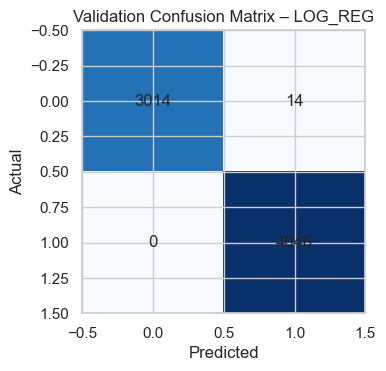

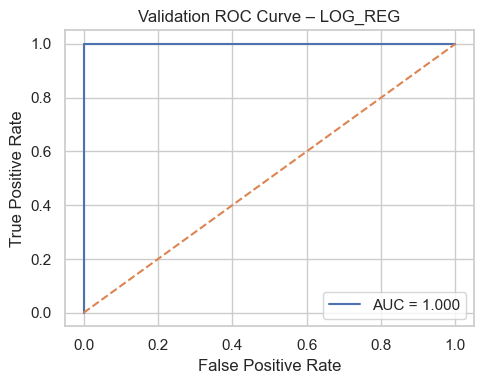

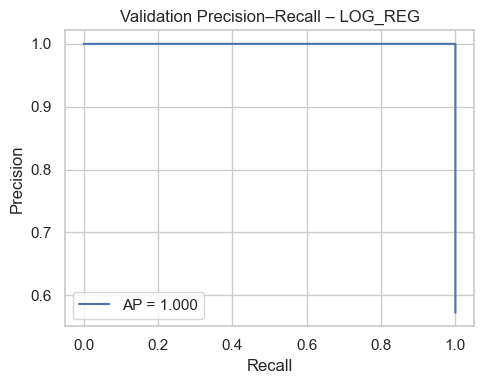


Validation classification report – rf:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3028
           1       1.00      1.00      1.00      4046

    accuracy                           1.00      7074
   macro avg       1.00      1.00      1.00      7074
weighted avg       1.00      1.00      1.00      7074



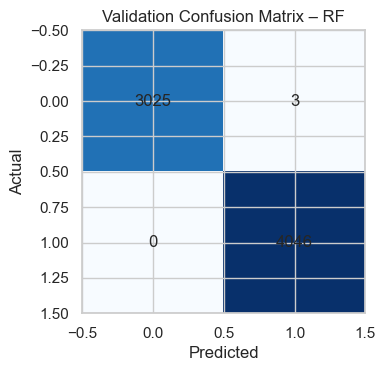

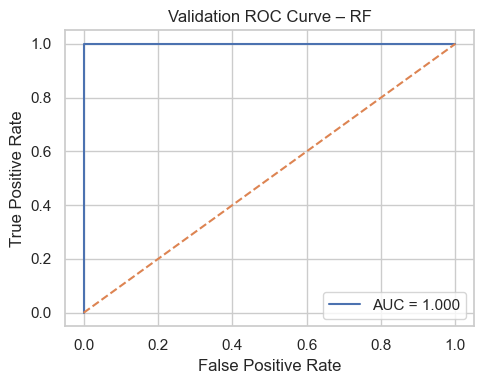

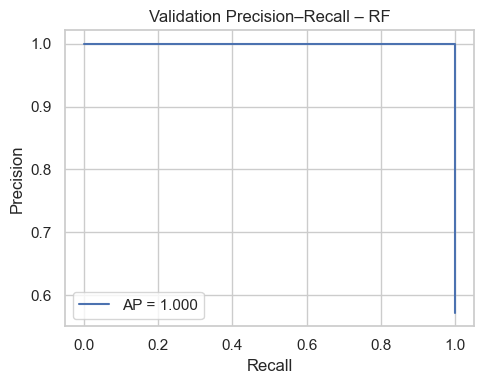


Validation classification report – svm:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3028
           1       1.00      1.00      1.00      4046

    accuracy                           1.00      7074
   macro avg       1.00      1.00      1.00      7074
weighted avg       1.00      1.00      1.00      7074



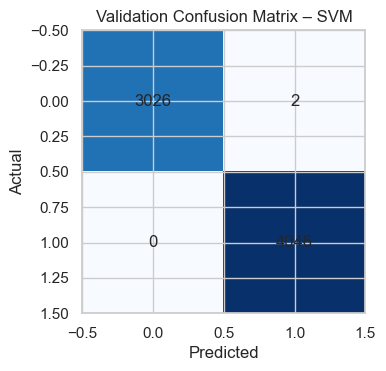

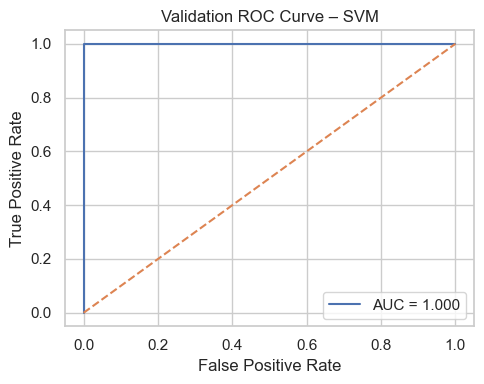

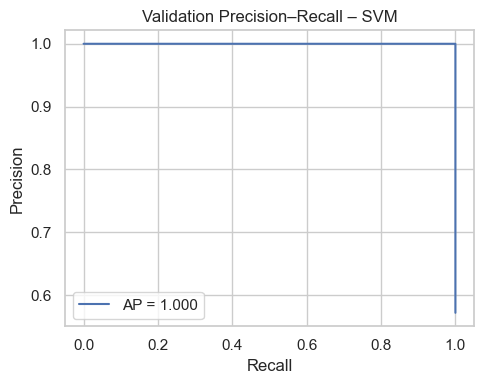

In [21]:
for name, grid in best_models.items():
    est = grid.best_estimator_

    y_pred_val = est.predict(X_valid_sel)

    if hasattr(est, 'predict_proba'):
        y_score_val = est.predict_proba(X_valid_sel)[:, 1]
    else:
        y_score_val = est.decision_function(X_valid_sel)

    print(f'\nValidation classification report – {name}:')
    print(classification_report(y_valid, y_pred_val))

    cm_val = confusion_matrix(y_valid, y_pred_val)
    plt.figure(figsize=(4, 4))
    plt.imshow(cm_val, cmap='Blues')
    plt.title(f'Validation Confusion Matrix – {name.upper()}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    for (i, j), val in np.ndenumerate(cm_val):
        plt.text(j, i, str(val), ha='center', va='center')
    plt.tight_layout()
    plt.show()

    fpr_val, tpr_val, _ = roc_curve(y_valid, y_score_val)
    try:
        auc_val = roc_auc_score(y_valid, y_score_val)
    except ValueError:
        auc_val = float('nan')

    plt.figure(figsize=(5, 4))
    plt.plot(fpr_val, tpr_val, label=f'AUC = {auc_val:.3f}')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Validation ROC Curve – {name.upper()}')
    plt.legend()
    plt.tight_layout()
    plt.show()

    precision_val, recall_val, _ = precision_recall_curve(y_valid, y_score_val)
    ap_val = average_precision_score(y_valid, y_score_val)

    plt.figure(figsize=(5, 4))
    plt.plot(recall_val, precision_val, label=f'AP = {ap_val:.3f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Validation Precision–Recall – {name.upper()}')
    plt.legend(loc='lower left')
    plt.tight_layout()
    plt.show()


## 12. Test-set metrics (20% held-out)

Finally, we evaluate the chosen models on the 20% test set, which was never used for training, CV, or validation.


In [22]:
test_results = []

for name, grid in best_models.items():
    est = grid.best_estimator_

    y_pred_test = est.predict(X_test_sel)

    if hasattr(est, 'predict_proba'):
        y_score_test = est.predict_proba(X_test_sel)[:, 1]
    else:
        y_score_test = est.decision_function(X_test_sel)

    metrics_test = binary_metrics(y_test, y_pred_test, y_score_test)
    metrics_test['model'] = name
    test_results.append(metrics_test)

test_metrics_df = pd.DataFrame(test_results).set_index('model').sort_values('f1', ascending=False)
print('Test-set metrics (20% held-out):')
display(test_metrics_df)


Test-set metrics (20% held-out):


,accuracy,balanced_acc,precision,recall,specificity,npv,f1,mcc,roc_auc,pr_auc,log_loss
model,,,,,,,,,,,
svm,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.0,1.0,0.003437
rf,0.999788,0.999752,0.999629,1.0,0.999505,1.0,0.999815,0.999567,1.0,1.0,0.009902
log_reg,0.997455,0.997028,0.995570,1.0,0.994056,1.0,0.997780,0.994813,1.0,1.0,0.005248


### 12.1 Test confusion matrices, ROC, Precision–Recall, and threshold curves



Test classification report – log_reg:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2019
           1       1.00      1.00      1.00      2697

    accuracy                           1.00      4716
   macro avg       1.00      1.00      1.00      4716
weighted avg       1.00      1.00      1.00      4716



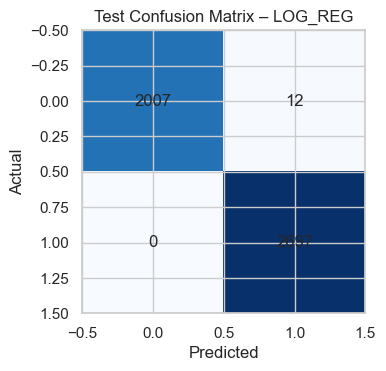

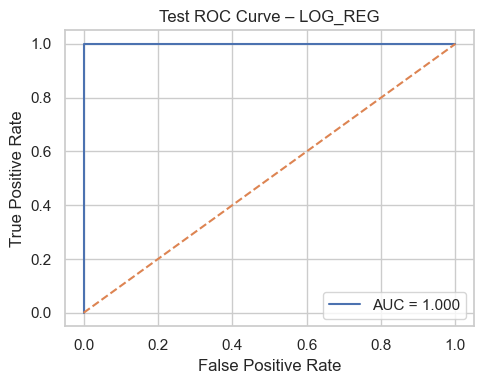

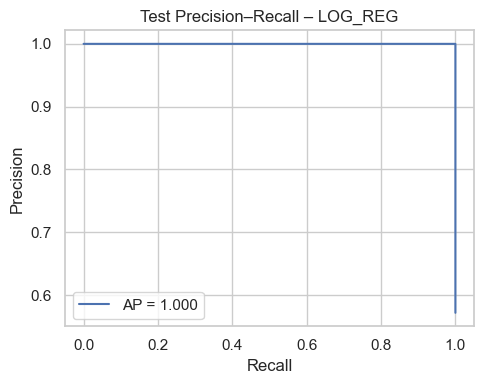

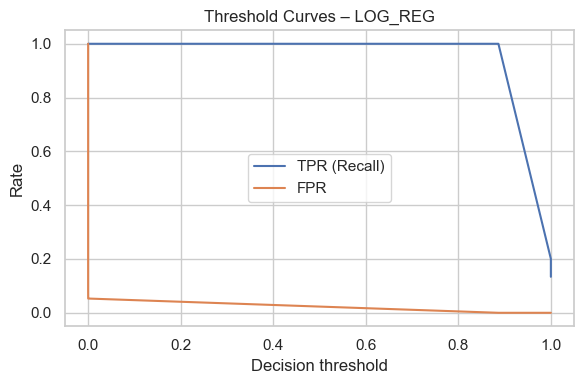


Test classification report – rf:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2019
           1       1.00      1.00      1.00      2697

    accuracy                           1.00      4716
   macro avg       1.00      1.00      1.00      4716
weighted avg       1.00      1.00      1.00      4716



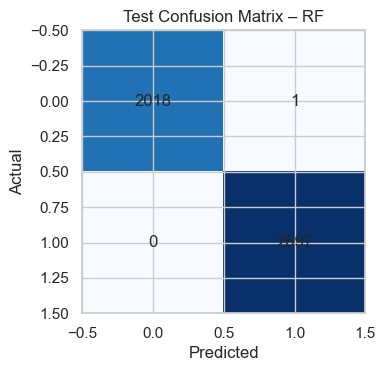

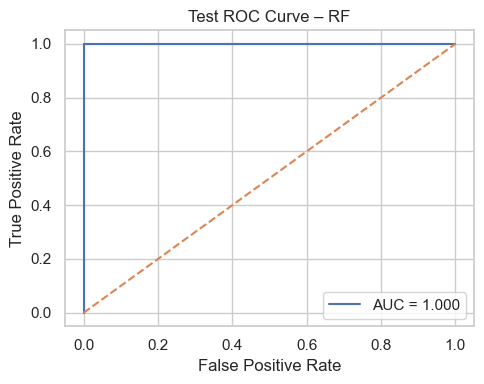

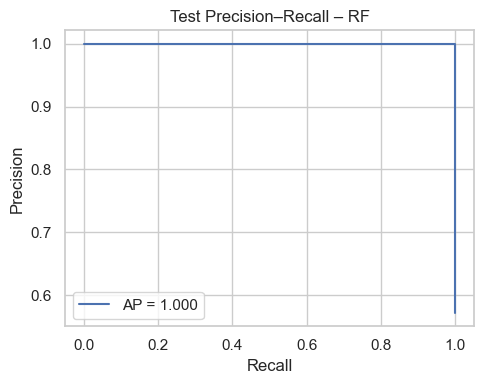

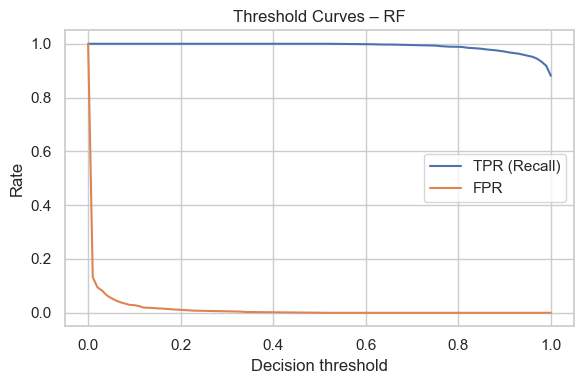


Test classification report – svm:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2019
           1       1.00      1.00      1.00      2697

    accuracy                           1.00      4716
   macro avg       1.00      1.00      1.00      4716
weighted avg       1.00      1.00      1.00      4716



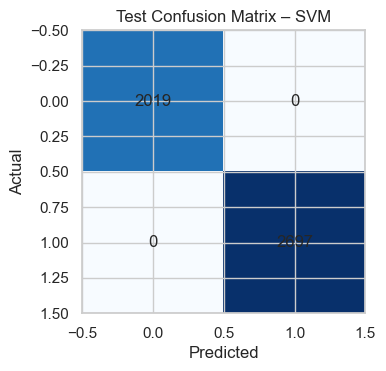

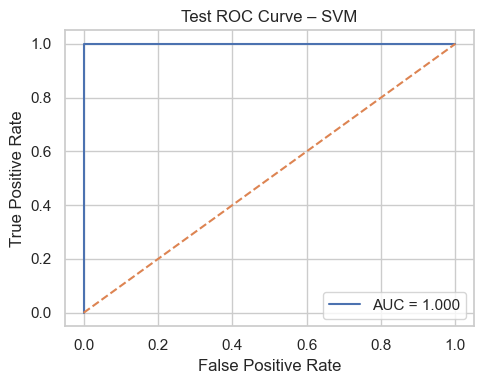

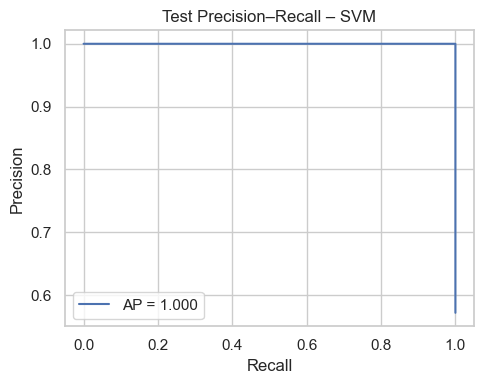

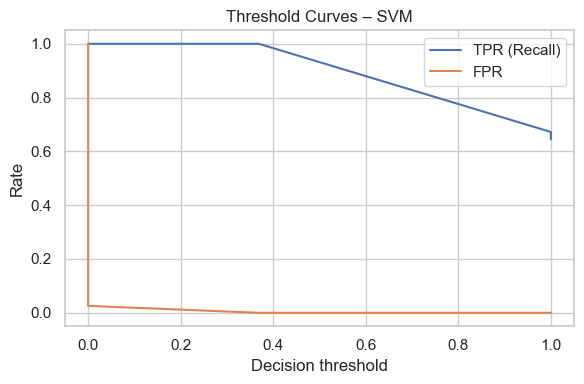

In [24]:
for name, grid in best_models.items():
    est = grid.best_estimator_

    y_pred_test = est.predict(X_test_sel)

    if hasattr(est, 'predict_proba'):
        y_score_test = est.predict_proba(X_test_sel)[:, 1]
    else:
        y_score_test = est.decision_function(X_test_sel)

    print(f'\nTest classification report – {name}:')
    print(classification_report(y_test, y_pred_test))

    cm_test = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(4, 4))
    plt.imshow(cm_test,cmap='Blues')
    plt.title(f'Test Confusion Matrix – {name.upper()}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    for (i, j), val in np.ndenumerate(cm_test):
        plt.text(j, i, str(val), ha='center', va='center')
    plt.tight_layout()
    plt.show()

    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_score_test)
    try:
        auc_test = roc_auc_score(y_test, y_score_test)
    except ValueError:
        auc_test = float('nan')

    plt.figure(figsize=(5, 4))
    plt.plot(fpr_test, tpr_test, label=f'AUC = {auc_test:.3f}')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Test ROC Curve – {name.upper()}')
    plt.legend()
    plt.tight_layout()
    plt.show()

    precision_test, recall_test, _ = precision_recall_curve(y_test, y_score_test)
    ap_test = average_precision_score(y_test, y_score_test)

    plt.figure(figsize=(5, 4))
    plt.plot(recall_test, precision_test, label=f'AP = {ap_test:.3f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Test Precision–Recall – {name.upper()}')
    plt.legend(loc='lower left')
    plt.tight_layout()
    plt.show()

    thr = thresholds_test[1:]
    tpr_thr = tpr_test[1:]
    fpr_thr = fpr_test[1:]

    plt.figure(figsize=(6, 4))
    plt.plot(thr, tpr_thr, label='TPR (Recall)')
    plt.plot(thr, fpr_thr, label='FPR')
    plt.xlabel('Decision threshold')
    plt.ylabel('Rate')
    plt.title(f'Threshold Curves – {name.upper()}')
    plt.legend()
    plt.tight_layout()
    plt.show()


## 13. Combined ROC / PR / Threshold dashboard for best test model

We select the model with the best test F1 score and show a summary dashboard.


Best test-set model by F1: svm


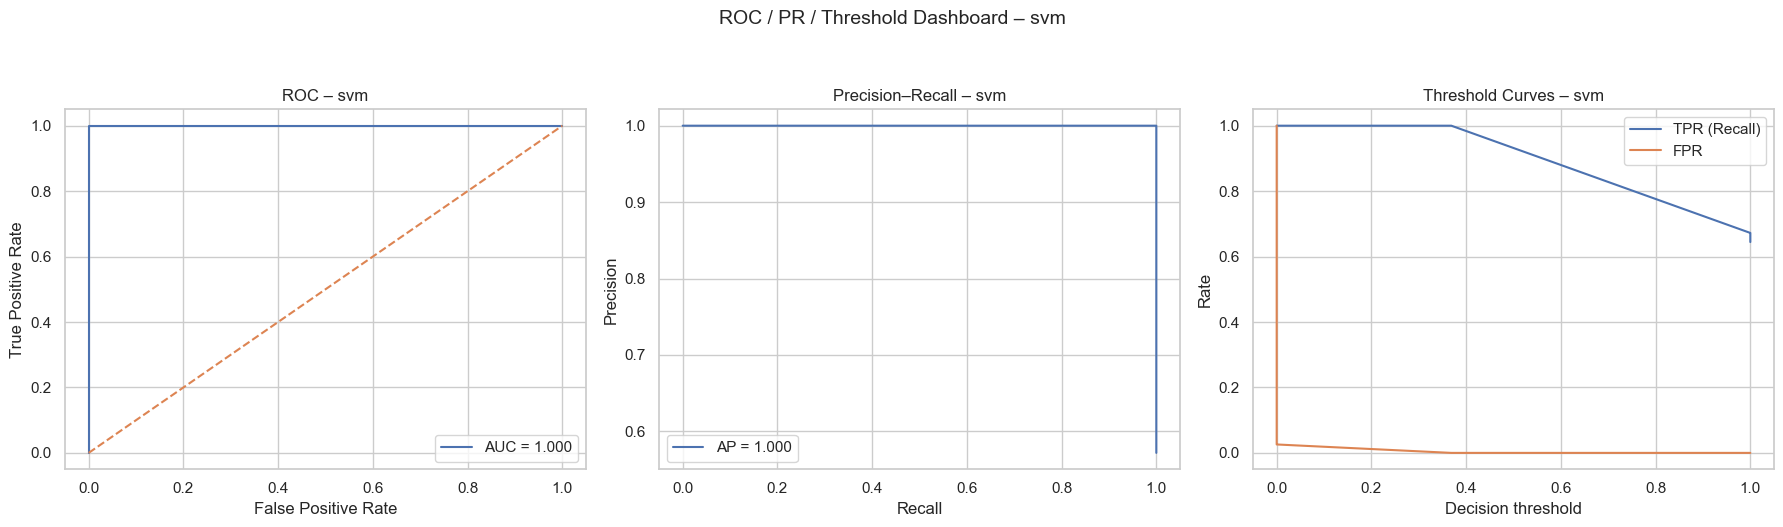

In [17]:
best_name = test_metrics_df.sort_values('f1', ascending=False).index[0]
print('Best test-set model by F1:', best_name)

best = best_models[best_name].best_estimator_

if hasattr(best, 'predict_proba'):
    y_score_best = best.predict_proba(X_test_sel)[:, 1]
else:
    y_score_best = best.decision_function(X_test_sel)

fpr_b, tpr_b, thr_b = roc_curve(y_test, y_score_best)
try:
    roc_auc_b = roc_auc_score(y_test, y_score_best)
except ValueError:
    roc_auc_b = float('nan')

prec_b, rec_b, _ = precision_recall_curve(y_test, y_score_best)
ap_b = average_precision_score(y_test, y_score_best)

thr_curve = thr_b[1:]
tpr_curve = tpr_b[1:]
fpr_curve = fpr_b[1:]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(fpr_b, tpr_b, label=f'AUC = {roc_auc_b:.3f}')
axes[0].plot([0, 1], [0, 1], linestyle='--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title(f'ROC – {best_name}')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(rec_b, prec_b, label=f'AP = {ap_b:.3f}')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title(f'Precision–Recall – {best_name}')
axes[1].legend(loc='lower left')
axes[1].grid(True)

axes[2].plot(thr_curve, tpr_curve, label='TPR (Recall)')
axes[2].plot(thr_curve, fpr_curve, label='FPR')
axes[2].set_xlabel('Decision threshold')
axes[2].set_ylabel('Rate')
axes[2].set_title(f'Threshold Curves – {best_name}')
axes[2].legend()
axes[2].grid(True)

plt.suptitle(f'ROC / PR / Threshold Dashboard – {best_name}', y=1.05, fontsize=14)
plt.tight_layout()
plt.show()


## 14. Learning curves (F1 vs training size)

We inspect learning curves for each tuned model using F1 as the scoring metric.


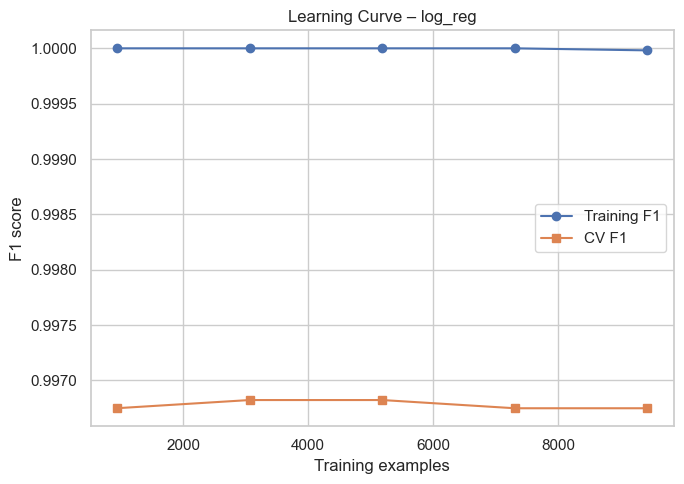

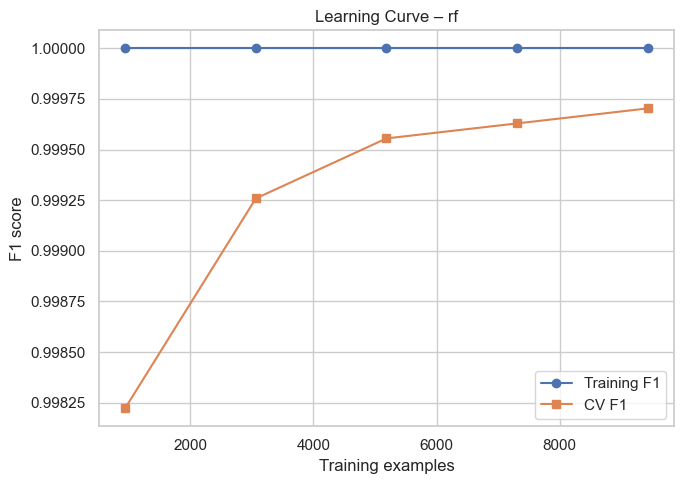

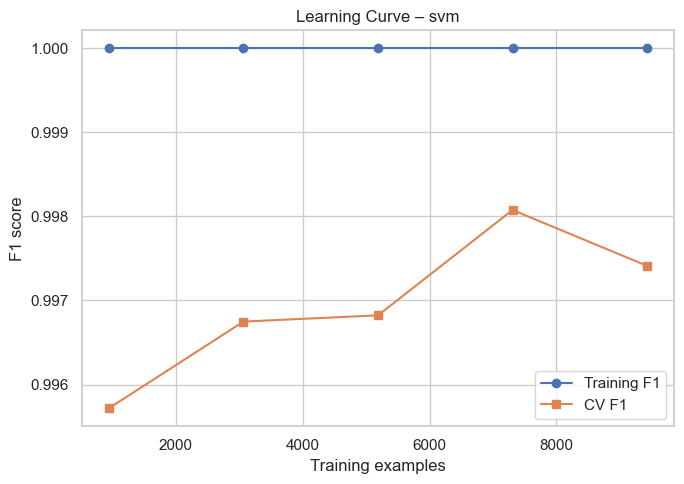

In [25]:
for name, grid in best_models.items():
    best = grid.best_estimator_

    train_sizes, train_scores, val_scores = learning_curve(
        best,
        X_train_sel,
        y_train,
        cv=cv,
        scoring='f1',
        train_sizes=np.linspace(0.1, 1.0, 5),
        n_jobs=-1,
    )

    train_mean = train_scores.mean(axis=1)
    val_mean = val_scores.mean(axis=1)

    plt.figure(figsize=(7, 5))
    plt.plot(train_sizes, train_mean, marker='o', label='Training F1')
    plt.plot(train_sizes, val_mean, marker='s', label='CV F1')
    plt.title(f'Learning Curve – {name}')
    plt.xlabel('Training examples')
    plt.ylabel('F1 score')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
